# Project Adcanved Lane Finding

This Project pursuit the $Land Finding$ with following steps:
    - Camera Calibration
    - Transforming into grey scale
    - Applaying Sobel Gradient Filter
    - Mask the image
    - Somthing the Image
    - Finding Lanes Histogramm Filter / Sliding Windows
    - Finding Lanes from Prio
    - Measuring Curve Radius
    - Output (drawing / paramters)   
---

## Camera Calibration

Undistort the image using cv2.undistort() with mtx and dist
    - Convert to grayscale
    - Find the chessboard corners
    - Draw corners
    - Define source points (the outer 4 corners detected in the chessboard pattern)
    - Define destination points (must be listed in the same order as src points!)
    - Use cv2.getPerspectiveTransform() to get M, the transform matrix
    - use cv2.warpPerspective() to apply M and warp your image to a top-down view
    
---

In [381]:
# Import all necessary packets

import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageDraw, ImageFont    # Needed for drawing text on image
from collections import deque                  # Needed to hold n values like a stack & list
import os
os.sys.path

['/Users/DanielD/Dokumente_Kopie/SelfDriving_Eng/04_CarND-Advanced-Lane-Lines-master',
 '/Users/DanielD/opt/miniconda3/envs/lane_detection/lib/python37.zip',
 '/Users/DanielD/opt/miniconda3/envs/lane_detection/lib/python3.7',
 '/Users/DanielD/opt/miniconda3/envs/lane_detection/lib/python3.7/lib-dynload',
 '',
 '/Users/DanielD/opt/miniconda3/envs/lane_detection/lib/python3.7/site-packages',
 '/Users/DanielD/opt/miniconda3/envs/lane_detection/lib/python3.7/site-packages/IPython/extensions',
 '/Users/DanielD/.ipython']

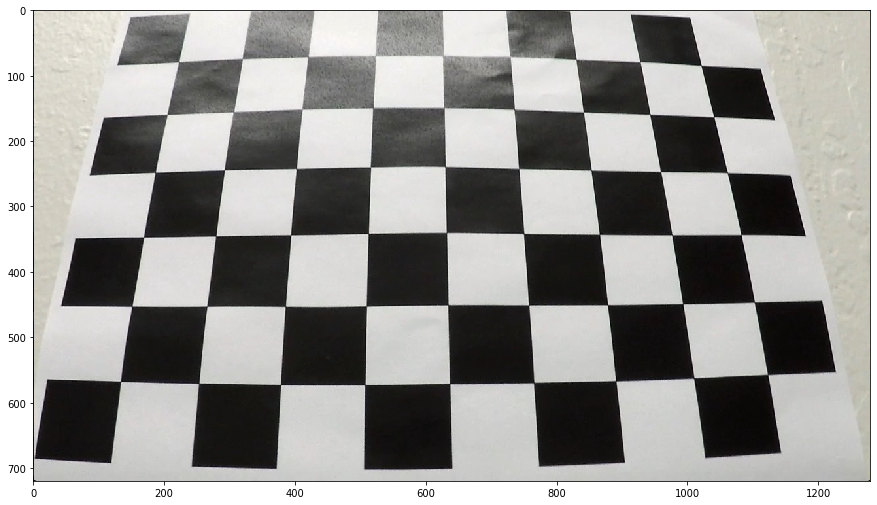

In [382]:
#Define the the size of the chessboard(Inner Corners)
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

#Read in the camera calibration image names
cam_cal_image_list = os.listdir("camera_cal/")


#create output directories if not existing
for path in ["output_images/camera_cal",
             "output_images/material_for_readme",
             "cam_params/"]:

    if not os.path.exists(path):
        os.makedirs(path)

#read and visualize one image. This is to verify the code
plt.figure(figsize = (15, 20))
img_orginal = mpimg.imread("camera_cal/"+cam_cal_image_list[3])
plt.imshow(img_orginal)

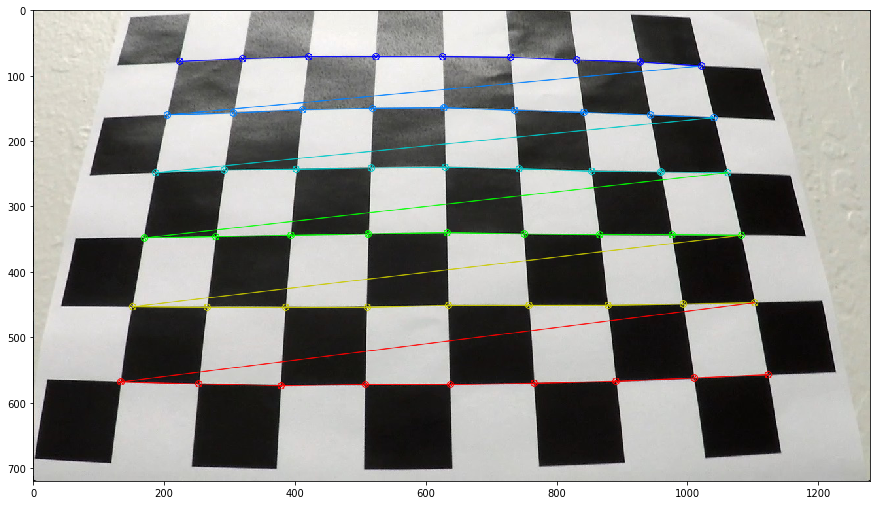

In [383]:
#convert image to grayscale
gray = cv2.cvtColor(img_orginal, cv2.COLOR_BGR2GRAY)

#find chessboard corners in grayscale image
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

#draw detected corners on the original image
img = cv2.drawChessboardCorners(img_orginal, (nx, ny), corners, ret)

#show original image with detected corners and save this image as example to be used in the readme
plt.figure(figsize = (15, 20))
plt.imshow(img)
mpimg.imsave("output_images/material_for_readme/"+cam_cal_image_list[3]+"chess_board_coners.png", img)

In [384]:
def corners_unwarp(img):
    # Function for drawing corners and unwrap the chess board. To proof the camera parameters
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.

    # prepare object points that have the size of the chees board
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # reshape the mgrid into row unknown, column 2 matrix

    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
    else: 
        return print('No corners found.')
        
    rv, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None) # Camera calibration, given object points, image points, and the shape of the grayscale image
    undist = cv2.undistort(img, mtx, dist, None,  mtx)   # Undistort using mtx and dist


    if rv == False:
        logger.error("Failed to parse checkerboard pattern in image")
        raise NotFoundError("Failed to parse checkerboard pattern in image")
         #If corners found:
            # a draw corners
    else:
        cv2.drawChessboardCorners(undist, (nx,ny), corners , ret) 
        offset = 75 # offset for dst points. 
        img_size = (gray.shape[1], gray.shape[0])
            #    Define 4 source points src = np.float32([[,],[,],[,],[,]])
                 #Note: you could pick any four of the detected corners 
                 # as long as those four corners define a rectangle
                 #One especially smart way to do this would be to use four well-chosen
                 # corners that were automatically detected during the undistortion steps
                 #We recommend using the automatic detection of corners in your code
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
            # Define 4 destination points dst = np.float32([[,],[,],[,],[,]])
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                        [img_size[0]-offset, img_size[1]-offset], 
                        [offset, img_size[1]-offset]])
            #  use cv2.getPerspectiveTransform() to get M, the transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
            #  use cv2.warpPerspective() to warp your image to a top-down view
        warped = cv2.warpPerspective(undist, M, img_size) 
    return warped, M, mtx, dist

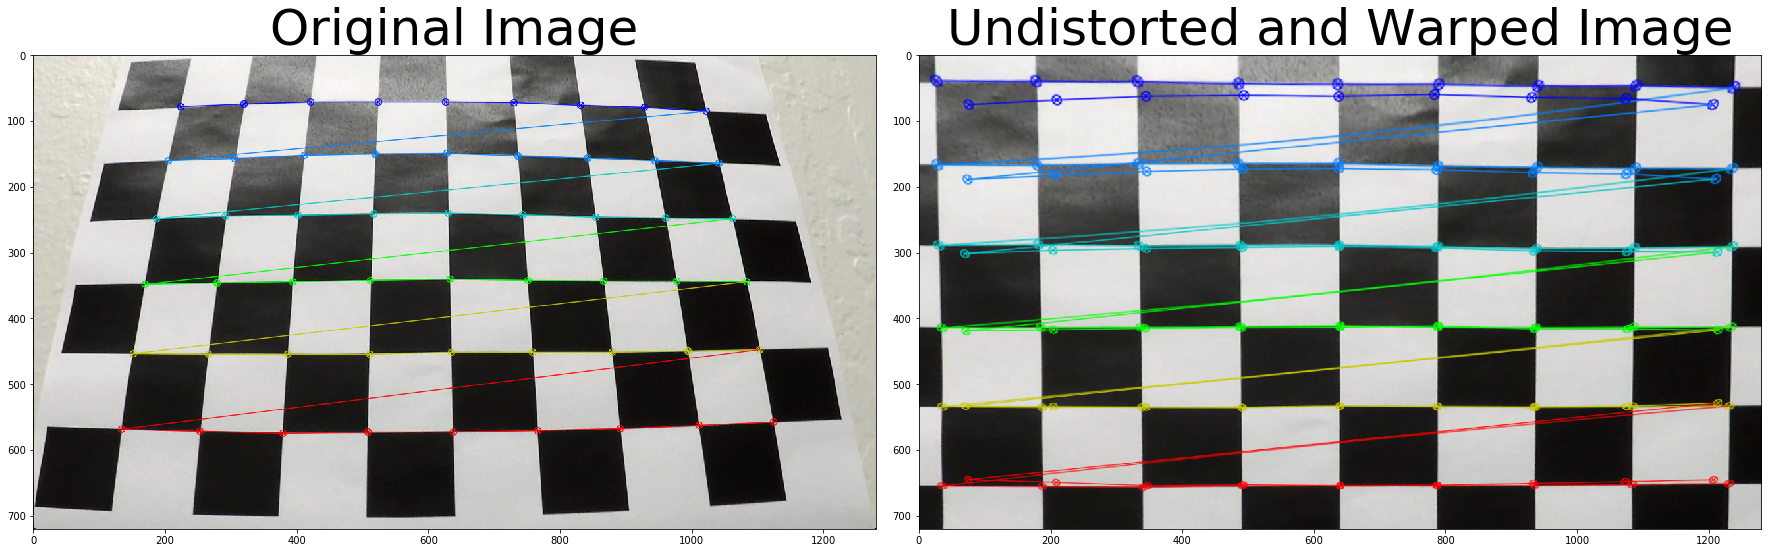

In [385]:
# Show one example
top_down, perspective_M, mtx, dist   = corners_unwarp(img_orginal)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

mpimg.imsave("output_images/material_for_readme/"+"UndistoredAndWramped.png", top_down)

In [386]:
# safe function for pickle data
def save_pickle(mtx, dist, image_name):
#safe camera parameters
    with open ('cam_params/'+image_name +'.pl', 'wb') as f:
        pickle.dump((mtx, dist), f)
    return

In [387]:
# Iterating over all chessboards images to unwrap the images and save the camera parameters

for cam_cal_name in cam_cal_image_list:
    #Skip .DS_Store Datas on Mac
    if cam_cal_name =='.DS_Store':
        continue
    
    img = mpimg.imread("camera_cal/"+cam_cal_name)
    warped, M, mtx, dist = corners_unwarp(img)
    save_pickle(mtx, dist, cam_cal_name)
    mpimg.imsave("output_images/camera_cal/Undistored_Wramped"+cam_cal_name, top_down)
    

## Detect Lines 

- Get the image
- Detect the Lines (Histogram Filter)
- Draw the Lines
- Detect the curvatur

---

### Create Class for the Line Detection

In [388]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #deque holding all the x_line values over the last n iterations
        self.stack_x = deque([], maxlen=10)
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        #deque holding all the polynominal coefficients over the last n iterations
        self.stack_polynominal = deque([], maxlen=10)
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  

In [389]:
# Declear a the Line classes
Right_L = Line ()
Left_L  = Line ()

### Get Image

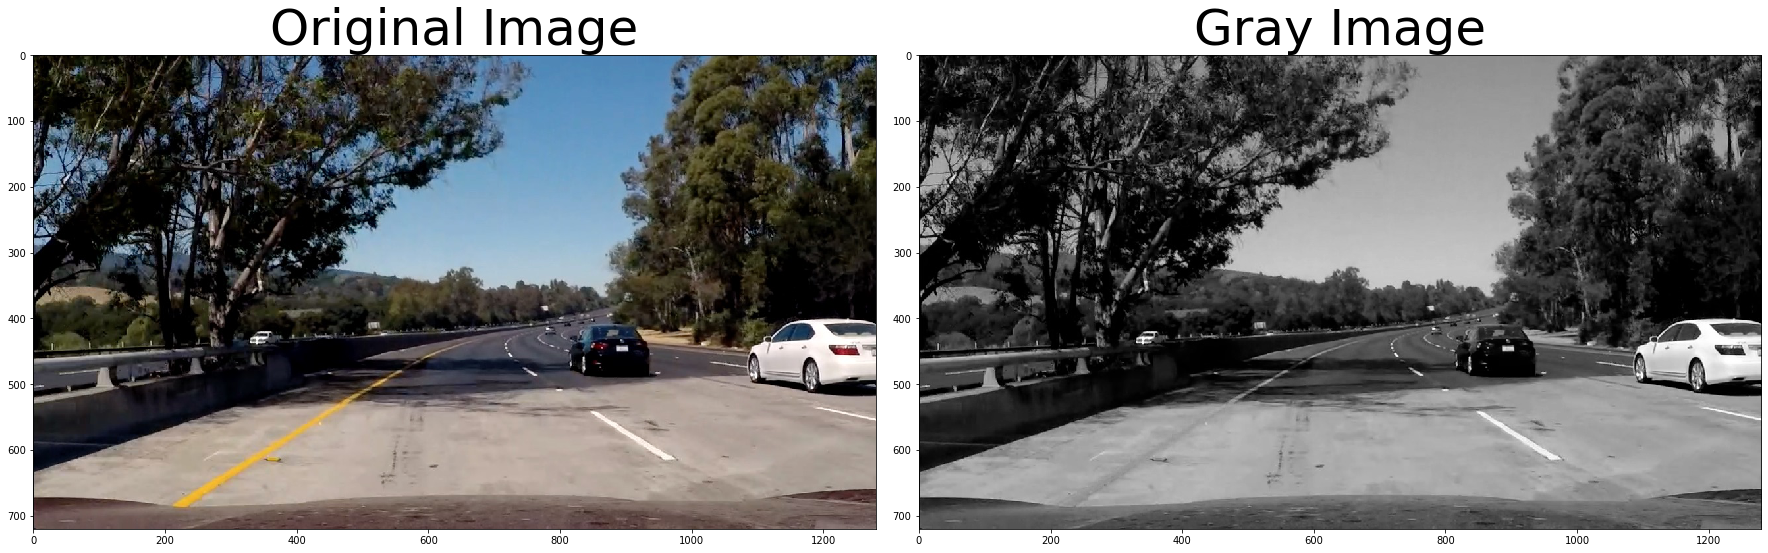

In [390]:
#Read in the Testing image names
image_list = os.listdir("test_images/")
#Read in Image
img_orginal = mpimg.imread("test_images/"+image_list[2])
#Graying the image
gray = cv2.cvtColor(img_orginal,cv2.COLOR_BGR2GRAY)

undist = cv2.undistort(img, mtx, dist, None,  mtx)

# Show the example to verify the code
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_orginal)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(gray, cmap='gray')
ax2.set_title('Gray Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

mpimg.imsave("output_images/material_for_readme/Orginal_Gray_Test_img.png", gray, cmap='gray')

### Applaying Sobel and Filter

In [391]:
# Read in the parmeters from the camera calibration 
# Read in the Parameter names
cam_parameter_list = os.listdir("cam_params/") 
dist_pickle = pickle.load( open( "cam_params/" + cam_parameter_list[1], "rb" ) ) # Grab any Parmeter Set, they all the same
mtx = dist_pickle[0]
dist = dist_pickle[1]    

In [392]:
# Pipeline for applying filters
def Sobel__SSpace_pipeline(img, s_thresh=(100, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color S-channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary, combined_binary,#sxbinary, s_binary
    

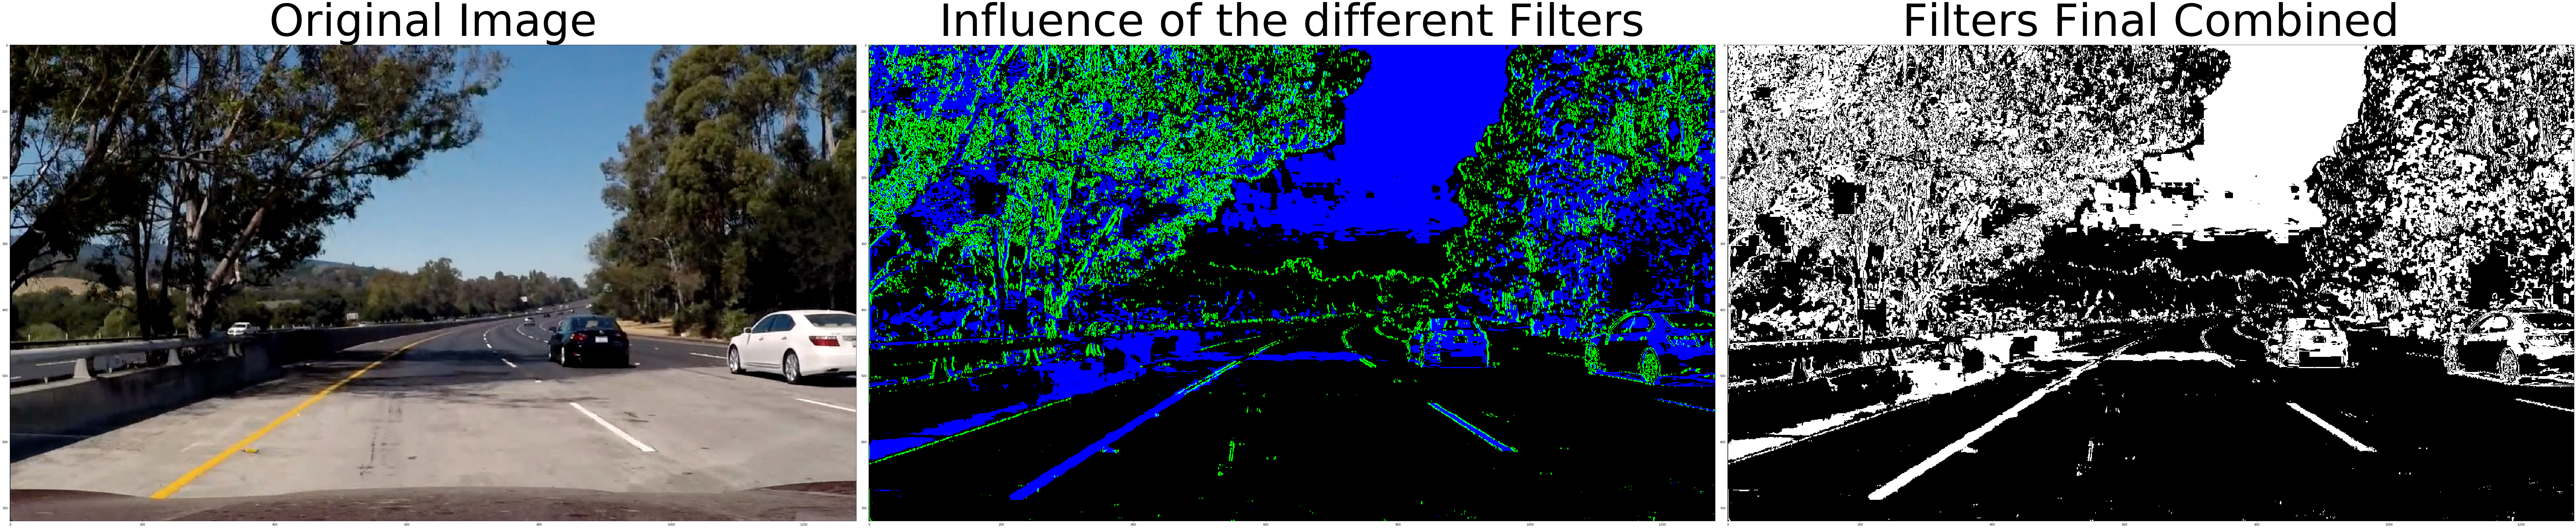

In [393]:
#Applay Filter to detect make the line lines visable
color_binary, combined_binary = Sobel__SSpace_pipeline(img_orginal)

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(120, 31))
f.tight_layout()

ax1.imshow(img_orginal)
ax1.set_title('Original Image', fontsize=150)

ax2.imshow(color_binary, cmap='gray')                 # Blue is S-Channel
ax2.set_title('Influence of the different Filters', fontsize=150)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

ax3.imshow(combined_binary, cmap='gray')
ax3.set_title('Filters Final Combined', fontsize=150)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.savefig("output_images/material_for_readme/Sobel_SSpaceFilter_Apply.png")

### Unwrampe the interesting road area (Birds view)

In [394]:
# Read in the parmeters from the camera calibration 
# Read in the Parameter names
cam_parameter_list = os.listdir("cam_params/") 
dist_pickle = pickle.load( open( "cam_params/" + cam_parameter_list[1], "rb" ) ) # Grab any Parmeter Set, they all the same
mtx = dist_pickle[0]
dist = dist_pickle[1] 

In [395]:
def road_unwarp(img,mtx, dist):
    # Pass in your image into this function
    # Undistort using mtx and dist
    undist = cv2.undistort(img, mtx, dist, None,  mtx)
    #gray = cv2.cvtColor(undist,cv2.COLOR_BGR2GRAY)
    
    offset = 100 # offset for dst points
    
    img_size = (img.shape[1], img.shape[0])
    # Define 4 source points src = np.float32([[,],[,],[,],[,]])
        #That should be transformed 
    leftdown = [240,690]
    leftup   = [565, 470]
    rightdown= [1070,690]
    rightup  = [717,470]
    src = np.float32([leftup, rightup, rightdown, leftdown])
    #define array of destination points
    offset_up = 100
    offset_lo = 30
    offset_l = 240
    offset_r = 210
    dst = np.float32([[offset_l, offset_up], [img.shape[1]-offset_r, offset_up],\
    [img.shape[1]-offset_r, img.shape[0]-offset_lo], [offset_l, img.shape[0]-offset_lo]])
    #dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
    #                [img_size[0]-offset, img_size[1]-offset], 
    #                [offset, img_size[1]-offset]])
         # Use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src) # M inverse
            # Use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size)

    return warped, M, Minv 

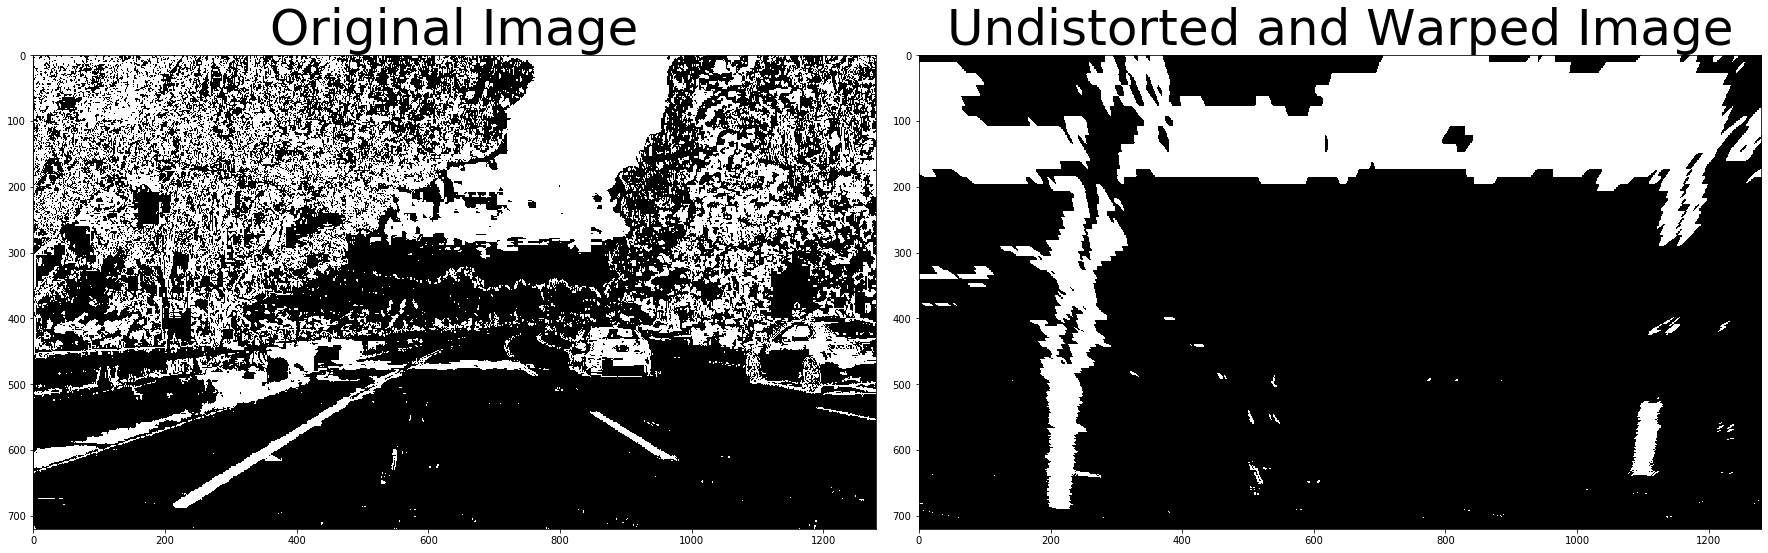

In [396]:
warped, M, Minv = road_unwarp(combined_binary,mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined_binary,cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped,cmap='gray')
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.savefig("output_images/material_for_readme/Undistored_Warped_Road_Area.png")

### Histogram Filter

In [397]:
def Histogram(img):
    '''
    Historgram for Finding the Vehicle Center and the Lane Lines
    '''
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    return leftx_base, rightx_base, midpoint

In [398]:
def Lane_Position(leftx_base, rightx_base, midpoint):
    '''
    Calculating the Vehicle center in reference to the Lane Line Middle
    '''
    # Define conversions in x and y from pixels space to meters
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Calculating
    lane_width = np.absolute(leftx_base + rightx_base)  * xm_per_pix 
    #vehicle_center = (midpoint - lane_width) * xm_per_pix                   # The Vehical center differenz to the Lane Line Middle in m
    vehicle_dist_left = (midpoint - leftx_base) * xm_per_pix                 # Vehical Distance to the Left
    vehicle_dist_right = (midpoint - rightx_base) * xm_per_pix               # Vehical Distance to the Right
    vehicle_position_lane = (midpoint* xm_per_pix) - (lane_width / 2)        # The Vehical center differenz to the Lane Line Middle in m
    
    return vehicle_position_lane,vehicle_dist_left, vehicle_dist_right, lane_width

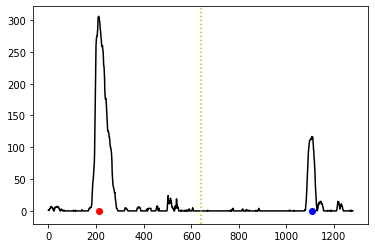

<Figure size 432x288 with 0 Axes>

In [399]:
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)

leftx_base, rightx_base, midpoint = Histogram(warped)
vehicle_position_lane,Left_L.line_base_pos, Right_L.line_base_pos, lane_width = Lane_Position(leftx_base, rightx_base, midpoint)

plt.figure()
plt.plot(histogram, c='k')
plt.axvline(midpoint, c='y', ls=':')
plt.scatter([leftx_base], [0], c='r')
plt.scatter([rightx_base], [0], c='b')

plt.show()
plt.savefig("output_images/material_for_readme/Undistored_Warped_Road_Area_Histogram.png")

### Sliding Windows

In [400]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    Left_L.allx = nonzerox[left_lane_inds]
    Left_L.ally = nonzeroy[left_lane_inds] 
    Right_L.allx = nonzerox[right_lane_inds]
    Right_L.ally = nonzeroy[right_lane_inds]
    
    return out_img

In [401]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    Left_L.current_fit = np.polyfit(Left_L.ally,  Left_L.allx, 2)
    Right_L.current_fit = np.polyfit(Right_L.ally, Right_L.allx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        
        Left_L.recent_xfitted = Left_L.current_fit[0]*ploty**2 + Left_L.current_fit[1]*ploty + Left_L.current_fit[2]
        Right_L.recent_xfitted = Right_L.current_fit[0]*ploty**2 + Right_L.current_fit[1]*ploty + Right_L.current_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        Left_L.recent_xfitted = 1*ploty**2 + 1*ploty
        Right_L.recent_xfitted = 1*ploty**2 + 1*ploty
        Left_L.detected = False
        Right_L.detected = False

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[Left_L.ally, Left_L.allx] = [255, 0, 0]
    out_img[Right_L.ally, Right_L.allx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(Left_L.recent_xfitted, ploty, color='yellow')
    plt.plot(Right_L.recent_xfitted, ploty, color='yellow')

    return out_img

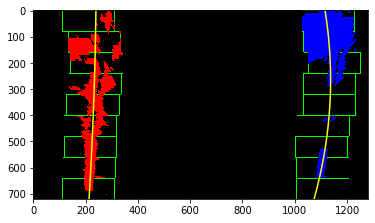

In [402]:
out_img = fit_polynomial(warped)

plt.imshow(out_img)

plt.savefig("output_images/material_for_readme/Sliding_Window_Polynomial.png")

## Search from Prio

In [403]:
def fit_poly(img_shape):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    Left_L.current_fit = np.polyfit(Left_L.ally,  Left_L.allx, 2)
    Right_L.current_fit = np.polyfit(Right_L.ally, Right_L.allx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    Left_L.recent_xfitted = Left_L.current_fit[0]*ploty**2 + Left_L.current_fit[1]*ploty + Left_L.current_fit[2]
    Right_L.recent_xfitted = Right_L.current_fit[0]*ploty**2 + Right_L.current_fit[1]*ploty + Right_L.current_fit[2]
    
    return ploty

In [404]:
def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    win_xleft_low = Left_L.current_fit[0]*nonzeroy**2 + Left_L.current_fit[1]*nonzeroy + Left_L.current_fit[2] - margin
    win_xleft_high = Left_L.current_fit[0]*nonzeroy**2 + Left_L.current_fit[1]*nonzeroy + Left_L.current_fit[2] + margin
    win_xright_low = Right_L.current_fit[0]*nonzeroy**2 + Right_L.current_fit[1]*nonzeroy + Right_L.current_fit[2] - margin
    win_xright_high = Right_L.current_fit[0]*nonzeroy**2 + Right_L.current_fit[1]*nonzeroy + Right_L.current_fit[2] + margin
    
    left_lane_inds = ((nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    right_lane_inds = ((nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    
    # Extract left and right line pixel positions
    Left_L.allx = nonzerox[left_lane_inds]
    Left_L.ally = nonzeroy[left_lane_inds] 
    Right_L.allx = nonzerox[right_lane_inds]
    Right_L.ally = nonzeroy[right_lane_inds]

    # Fit new polynomials
    ploty = fit_poly(binary_warped.shape)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([Left_L.recent_xfitted-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([Left_L.recent_xfitted+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([Right_L.recent_xfitted-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([Right_L.recent_xfitted+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    draw_line_wraped_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(Left_L.recent_xfitted, ploty, color='yellow')
    plt.plot(Right_L.recent_xfitted, ploty, color='yellow')
    ## End visualization steps ##
    
    return draw_line_wraped_img

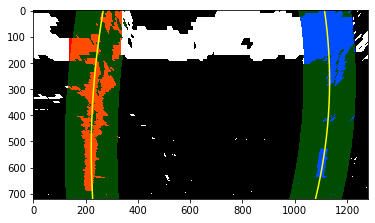

In [405]:
# Run image through the pipeline
result = search_around_poly(warped)

# View your output
plt.imshow(result)

plt.savefig("output_images/material_for_readme/Search_Prio.png")

### Curvature

In [406]:
def curvature_check(radius_l, radius_r):
    '''
    Plausability check for the curvature. Outside the US raod regulation the radius will not be displayed.
    '''
    if ((radius_l < 195) or (radius_r < 195) or (radius_l > 1221) or (radius_l > 1221)):    # If outside US Goverments spec no curve
        radius_l = 0
        radius_r = 0      # No curvature detected   
    return radius_l, radius_r

In [407]:
def measure_curvature_real(img,leftx,lefty, rightx, righty):
    '''
    Calculates the curvature of polynomial functions in meters.
    ''' 
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    img_shape = img.shape
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) // np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) // np.absolute(2*right_fit_cr[0])
    
    radius_l, radius_r = curvature_check(left_curverad, right_curverad)
    return radius_l, radius_r

In [408]:
Left_L.radius_of_curvature, Right_L.radius_of_curvature = measure_curvature_real(warped,Left_L.allx,Left_L.ally, Right_L.allx, Right_L.ally)
        

In [409]:
print(Left_L.radius_of_curvature, 'm', Right_L.radius_of_curvature, 'm')

1032.0 m 620.0 m


###  Sanity Check

In [410]:
def sanity_check(radius_l, radius_r, lane_width, poly1, poly2):
    '''Checks if the given data is plausible
    1) similar curvature
    2) separated by approximately the right distance horizontally
    3) Parallel lines, similar plynomes
    '''
    Sanity_Check = False
    
    if np.abs(radius_l -radius_r) < ((np.abs(radius_l + radius_r)/2) * 0.5):   # check if the difference is bigger than 50% of the  mean 
        Sanity_Check = True
    if lane_width > 2.5 and lane_width < 3.5:
        Sanity_Check = True
    if np.abs(poly1[1] - poly2[1]) < ((np.abs(poly1[1] + poly2[1])/2) * 0.5):     # check if the difference is bigger than 5% of the  mean 
        Sanity_Check = True
        
    return Sanity_Check

### Drawing  

In [411]:
 # Create an image to draw the lines on
def draw(undist,warped,Minv, left_fitx, right_fitx):
    '''
    Function that unwarpad the waped area an draw the founded lines into it the orginal image
    ''' 
    img_shape = warped.shape
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img_shape[1], img_shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

In [412]:
# Writing text on the Image

def text_image(img, message1,message2 ):
    '''Function to draw tex to the image
    '''
    img_text = cv2.putText(img,'Distance to road center = '+str(np.around(message1,2))+'m',(50, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
        
    img_text_final = cv2.putText(img_text,'Radius of Curvature = '+str(np.around(message2,2))+'m',(50, 120), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    
    return img_text_final

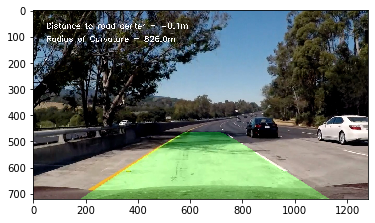

In [413]:
result_2 = draw(img_orginal, warped,Minv, Left_L.recent_xfitted,  Right_L.recent_xfitted)    
img_text = text_image(result_2, vehicle_position_lane,((Left_L.radius_of_curvature+Right_L.radius_of_curvature)/2) )

#plt.imshow(result_2)
plt.imshow(img_text)

plt.savefig("output_images/material_for_readme/Drawning_Final_Result.png")

# Video Pipline

There are 3 videos. The first one is the Project video. The code and parameters are developed for this video. 
The second video will need an additional approach that is not covered in this project. This is figure out the strength and weakness of the code. For the last video is also a deep leaning approach needed, for this I do not have the skills yet.

### Initialisation

In [374]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [375]:
# Read in the parmeters from the camera calibration 
# Read in the Parameter names
cam_parameter_list = os.listdir("cam_params/") 
dist_pickle = pickle.load( open( "cam_params/" + cam_parameter_list[1], "rb" ) ) # Grab any Parmeter Set, they all the same
mtx = dist_pickle[0]
dist = dist_pickle[1]  

In [376]:
#create output directories if not existing
for path in ["output_videos"]:

    if not os.path.exists(path):
        os.makedirs(path)

### Pre Work Somoothing

In [377]:
def smoothing_polynominal(poly_left,poly_right):
    
    Left_L.stack_polynominal.append(poly_left)     # Appending the given polynominal to the stack
    Right_L.stack_polynominal.append(poly_right)   # The Stack react First in First out
    
    #Left Side
    poly2_sum=0; poly1_sum=0; poly0_sum=0;         # initialize to zero
    for x in Left_L.stack_polynominal:
        poly2_sum += x[0] ; poly1_sum += x[1] ; poly0_sum += x[2]
        
    poly2_mean = poly2_sum / len(Left_L.stack_polynominal) ; poly1_mean = poly1_sum / len(Left_L.stack_polynominal) ; poly0_mean = poly0_sum / len(Left_L.stack_polynominal)
    
    poly_left_smooth = [poly2_mean, poly1_mean, poly0_mean]
    
    #Right Side
    poly2_sum=0; poly1_sum=0; poly0_sum=0;         # initialize to zero
    for x in Right_L.stack_polynominal:
        poly2_sum += x[0] ; poly1_sum += x[1] ; poly0_sum += x[2]
        
    poly2_mean = poly2_sum / len(Right_L.stack_polynominal) ; poly1_mean = poly1_sum / len(Right_L.stack_polynominal) ; poly0_mean = poly0_sum / len(Right_L.stack_polynominal)
    poly_right_smooth = [poly2_mean, poly1_mean, poly0_mean]
    
    return poly_left_smooth, poly_right_smooth

In [378]:
def smooths_x_poly(warped_img, poly_left_smooth,poly_right_smooth):
    
    img_shape = warped_img.shape
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_bestx = poly_left_smooth[0]*ploty**2 + poly_left_smooth[1]*ploty + poly_left_smooth[2]
    right_bestx = poly_right_smooth[0]*ploty**2 + poly_right_smooth[1]*ploty + poly_right_smooth[2]
    
    return left_bestx, right_bestx

### Pipline

In [414]:
def video_pipe(img):
    #Applay Filter to detect make the lane lines visable
    color_binary, combined_binary = Sobel__SSpace_pipeline(img)
    # Warap area of interest 2D Bird view
    warped, M, Minv = road_unwarp(combined_binary,mtx, dist)
    # Detecting the Lane Lines with Histogram Filter
    leftx_base, rightx_base, midpoint = Histogram(warped)
    vehicle_position_lane,Left_L.line_base_pos, Right_L.line_base_pos,lane_width  = Lane_Position(leftx_base, rightx_base, midpoint)
    
    if ((Left_L.detected == False) or (Right_L.detected == False)):
        
        # Sliding Windows
        draw_lines_wraped_img = fit_polynomial(warped)
    else: 
        # Search from Proir
        draw_lines_wraped_img = search_around_poly(warped)
        
    # Sanity Check
    detected = sanity_check(Left_L.radius_of_curvature, Right_L.radius_of_curvature, lane_width, Left_L.current_fit, Right_L.current_fit)
    # Adjusting the detection Status
    Left_L.detected = detected ; Right_L.detected = detected;
    #Smoothing
    #If lane is detected the current polynominals are used, if not the last detected ones are used
    if ((Left_L.detected == True) or (Right_L.detected == True)):
        
        Left_L.best_fit, Right_L.best_fit = smoothing_polynominal(Left_L.current_fit,Right_L.current_fit)
        Left_L.bestx,Right_L.bestx        = smooths_x_poly(warped, Left_L.best_fit,Right_L.best_fit)
        # Curvature
        Left_L.radius_of_curvature, Right_L.radius_of_curvature = measure_curvature_real(warped,Left_L.allx,Left_L.ally, Right_L.allx, Right_L.ally) 
    
    # Drawing
    result = draw(img, warped,Minv, Left_L.bestx, Right_L.bestx)    
    img_text = text_image(result, vehicle_position_lane,((Left_L.radius_of_curvature+Right_L.radius_of_curvature)/2))
    
    return img_text 

### 1) Project Video

t:   1%|          | 2/225 [00:00<00:14, 15.55it/s, now=None]

Moviepy - Building video output_videos/project_video.mp4.
Moviepy - Writing video output_videos/project_video.mp4



Moviepy - Done !
Moviepy - video ready output_videos/project_video.mp4
CPU times: user 52.7 s, sys: 7.43 s, total: 1min
Wall time: 34 s


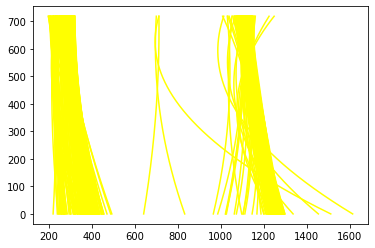

In [415]:
white_output = 'output_videos/project_video.mp4'

clip1 = VideoFileClip("project_video.mp4").subclip(36, 45)
#clip1 = VideoFileClip("challenge_video.mp4").subclip(4.78, 4.8)
#clip1 = VideoFileClip("challenge_video.mp4").subclip(3, 5)

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip('challenge_video.mp4').subclip(0,5)
#clip1 = VideoFileClip('project_video.mp4')
white_clip = clip1.fl_image(video_pipe) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [416]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

### 2) Challenge Video

t:   2%|▏         | 2/90 [00:00<00:05, 15.91it/s, now=None]

Moviepy - Building video output_videos/challenge_video_video.mp4.
Moviepy - Writing video output_videos/challenge_video_video.mp4



Moviepy - Done !
Moviepy - video ready output_videos/challenge_video_video.mp4
CPU times: user 18.1 s, sys: 2.64 s, total: 20.8 s
Wall time: 12.3 s


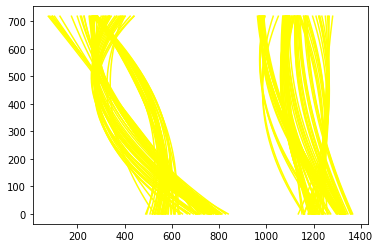

In [417]:
white_output = 'output_videos/challenge_video_video.mp4'

#clip1 = VideoFileClip("challenge_video.mp4").subclip(4.68, 4.7)
#clip1 = VideoFileClip("challenge_video.mp4").subclip(4.78, 4.8)
clip1 = VideoFileClip("challenge_video.mp4").subclip(0,3)
#np_frame = clip1.get_frame(0.14) # get the frame at t=2 seconds
#clip1.save_frame('challenge_1.jpeg', t=0.14) # save frame at t=2 as JPEG
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip('challenge_video.mp4')
clip1.save_frame('challenge_014.jpeg', t=0.14) # save frame at as JPEG
clip1.save_frame('challenge_2.jpeg', t=2)    # save frame at t=2 as JPEG
clip1.save_frame('challenge_3.jpeg', t=3) 

white_clip = clip1.fl_image(video_pipe) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [418]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

### 3) Harder Challenge

t:   0%|          | 2/1199 [00:00<01:26, 13.86it/s, now=None]

Moviepy - Building video output_videos/harder_challenge_video_video.mp4.
Moviepy - Writing video output_videos/harder_challenge_video_video.mp4



Moviepy - Done !
Moviepy - video ready output_videos/harder_challenge_video_video.mp4
CPU times: user 5min 1s, sys: 39.8 s, total: 5min 41s
Wall time: 3min 35s


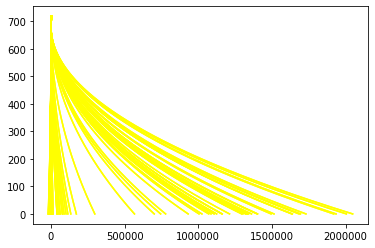

In [419]:
white_output = 'output_videos/harder_challenge_video_video.mp4'

#clip1 = VideoFileClip("challenge_video.mp4").subclip(4.68, 4.7)
#clip1 = VideoFileClip("challenge_video.mp4").subclip(4.78, 4.8)
#clip1 = VideoFileClip("challenge_video.mp4").subclip(3, 5)

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip('harder_challenge_video.mp4')

white_clip = clip1.fl_image(video_pipe) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [420]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))